In [1]:
import numpy as np
import gmsh
gmsh.initialize()

In [2]:
H = 0.5
L = 2.0

gmsh.model.add("cantilever")
gmsh.model.occ.addRectangle(0.0, 0.0, 0.0, L, H)
gmsh.model.occ.synchronize()

gmsh.model.addPhysicalGroup(1, [2], 5)
gmsh.model.addPhysicalGroup(1, [4], 6)
gmsh.model.addPhysicalGroup(2, [1])

gmsh.option.setNumber("Mesh.MeshSizeMax", 0.5)
gmsh.model.mesh.generate()

geometry = gmsh.model.mesh.getNodes()[1].reshape(-1, 3)
geometry = geometry[:, :2]

topology = gmsh.model.mesh.getElements(2)[2][0]
topology = topology.reshape(-1, 3) - 1
num_vertices = geometry.shape[0]

right_vertices = gmsh.model.mesh.getNodesForPhysicalGroup(1, 5)[0] - 1
left_vertices = gmsh.model.mesh.getNodesForPhysicalGroup(1, 6)[0] - 1

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [  0%] Meshing curve 2 (Line)
Info    : [  0%] Meshing curve 3 (Line)
Info    : [  0%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00106387s, CPU 0.003669s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0015185s, CPU 0.005711s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 1.375e-05s, CPU 5.9e-05s)
Info    : 49 nodes 100 elements


In [3]:
import matplotlib.tri

triangulation = matplotlib.tri.Triangulation(geometry[:, 0], geometry[:, 1], topology)

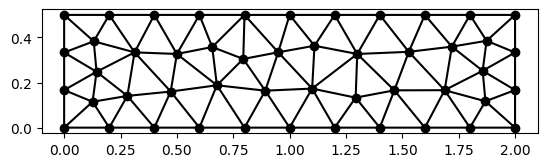

In [4]:
import matplotlib.pyplot as plt

plt.gca().set_aspect("equal")
plt.triplot(triangulation, marker="o", color="black")

tri
 [31 38 28]
tri_geometry
 [[1.46461005 0.16547928]
 [1.5286484  0.33626489]
 [1.3        0.32679492]]


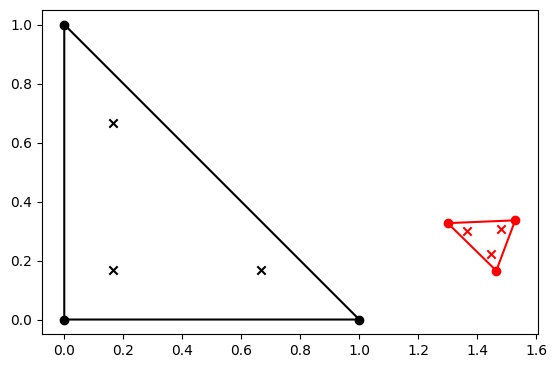

In [5]:
def F(vertices, xhat):
    xi = xhat.T[0]
    eta = xhat.T[1]
    return np.outer((1 - xi - eta), vertices[0]) + np.outer(xi, vertices[1]) + np.outer(eta, vertices[2])


reference_triangle = np.array([[0.0, 0.0], [1.0, 0], [0.0, 1.0]])
reference_points = np.array([[1/6, 1/6], [2/3, 1/6], [1/6, 2/3]])
plt.gca().set_aspect("equal")
plt.triplot(reference_triangle[:, 0], reference_triangle[:, 1], [[0, 1, 2]], marker="o", color="black")
plt.scatter(reference_points[:, 0], reference_points[:,1], color="black", marker="x")

n = 5
tri = topology[n]
tri_geometry = geometry[tri]
print("tri\n", tri)
print("tri_geometry\n", tri_geometry)

physical_triangle = F(tri_geometry, reference_triangle)
physical_points = F(tri_geometry, reference_points)

plt.triplot(physical_triangle[:, 0], physical_triangle[:, 1], [[0, 1, 2]], marker="o", color="red")
plt.scatter(physical_points[:, 0], physical_points[:, 1], color="red", marker="x")

In [6]:
dofmap = np.hstack((topology, topology + num_vertices))
print(f"Non-interleaved dofmap:\n{dofmap}")

Non-interleaved dofmap:
[[37 38 34 86 87 83]
 [36 39 35 85 88 84]
 [34 38 31 83 87 80]
 [35 39 29 84 88 78]
 [28 40 31 77 89 80]
 [31 38 28 80 87 77]
 [29 39 32 78 88 81]
 [33 40 28 82 89 77]
 [28 41 33 77 90 82]
 [32 43 29 81 92 78]
 [20 44 19 69 93 68]
 [42 44 20 91 93 69]
 [11 31 10 60 80 59]
 [22 29 21 71 78 70]
 [ 8 30  7 57 79 56]
 [30 32  7 79 81 56]
 [ 9 33  8 58 82 57]
 [ 8 33 30 57 82 79]
 [ 7 32  6 56 81 55]
 [18 28 17 67 77 66]
 [12 34 11 61 83 60]
 [23 35 22 72 84 71]
 [ 9 40 33 58 89 82]
 [32 39  6 81 88 55]
 [18 41 28 67 90 77]
 [31 40 10 80 89 59]
 [28 38 17 77 87 66]
 [11 34 31 60 83 80]
 [22 35 29 71 84 78]
 [25 26 24 74 75 73]
 [14 27 13 63 76 62]
 [21 43 20 70 92 69]
 [15 48  2 64 97 51]
 [ 4 46  0 53 95 49]
 [ 3 45 23 52 94 72]
 [ 1 47 12 50 96 61]
 [ 5 39 36 54 88 85]
 [16 38 37 65 87 86]
 [16 37 15 65 86 64]
 [ 5 36  4 54 85 53]
 [33 44 30 82 93 79]
 [27 37 34 76 86 83]
 [26 36 35 75 85 84]
 [12 47 34 61 96 83]
 [23 45 35 72 94 84]
 [17 38 16 66 87 65]
 [19 41 18

In [7]:
def u0(xi, eta):
    return (1 - xi - eta)

def u1(xi, eta):
    return xi

def u2(xi, eta):
    return eta

def du0dxi(xi, eta):
    return -1.0

def du0deta(xi, eta):
    return -1.0

def du1dxi(xi, eta):
    return 1.0

def du1deta(xi, eta):
    return 0.0

def du2dxi(xi, eta):
    return 0.0

def du2deta(xi, eta):
    return 1.0

def basis_deriv(xi, eta):
    return np.array([[du0dxi(xi, eta), du1dxi(xi, eta), du2dxi(xi, eta)],
                     [du0deta(xi, eta), du1deta(xi, eta), du2deta(xi, eta)]])

print(basis_deriv(1/3,1/3))

basis = [u0, u1, u2]

[[-1.  1.  0.]
 [-1.  0.  1.]]


In [8]:
def J(vertices):
    return np.vstack((vertices[1] - vertices[0], vertices[2] - vertices[0])).T

In [9]:
num_triangles = topology.shape[0]
print(f"Number of triangles: {num_triangles}")


E = 70 * 1e+9
nu = 0.33
h = 0.01
C = E / (1 - nu**2) * np.array([[1, nu, 0],
                                [nu, 1, 0],
                                [0, 0, (1 - nu) / 2]])

quadrature_point = np.array([1/3, 1/3])
quadrature_weights = np.array([1/2])

num_global_dofs = 2 * num_vertices
K = np.zeros((num_global_dofs, num_global_dofs))


def K_local(vertices):
    J_local = J(vertices)
    detJ = np.linalg.det(J_local)
    basis_deriv_local = basis_deriv(quadrature_point[0], quadrature_point[1])

    basis_deriv_physical = np.linalg.inv(J_local).T @ basis_deriv_local
    B0 = np.array([[basis_deriv_physical[0, 0], 0.0],
                   [0.0, basis_deriv_physical[1, 0]],
                   [basis_deriv_physical[1, 0], basis_deriv_physical[0, 0]]])   
    B1 = np.array([[basis_deriv_physical[0, 1], 0.0],
                   [0.0, basis_deriv_physical[1, 1]],
                   [basis_deriv_physical[1, 1], basis_deriv_physical[0, 1]]]) 
    B2 = np.array([[basis_deriv_physical[0, 2], 0.0],
                   [0.0, basis_deriv_physical[1, 2]],
                   [basis_deriv_physical[1, 2], basis_deriv_physical[0, 2]]])

    B = np.block([B0, B1, B2])
    BTCB = detJ*h*quadrature_weights[0] * B.T@C@B

    perm = np.array([0, 2, 4, 1, 3, 5]) 
    return BTCB[np.ix_(perm, perm)]


for i in range(num_triangles):
    vertices = geometry[topology[i]]
    cell_dofmap = dofmap[i]

    K_loc = K_local(vertices)
    K[np.ix_(cell_dofmap, cell_dofmap)] += K_loc

Number of triangles: 70


There are 90 free dofs and 8 Dirichlet dofs.


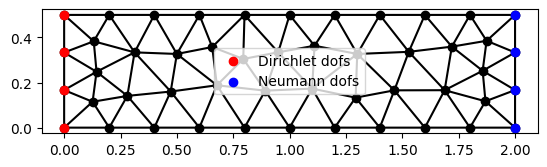

In [10]:
dirichlet_dofs_xy = np.hstack((left_vertices, left_vertices + num_vertices))

neumann_dofs = right_vertices + num_vertices

free_dofs = np.setdiff1d(np.arange(num_global_dofs, dtype=np.int32), dirichlet_dofs_xy)
print(f"There are {len(free_dofs)} free dofs and {len(dirichlet_dofs_xy)} Dirichlet dofs.")

plt.gca().set_aspect("equal")
plt.triplot(triangulation, marker="o", color="black")
plt.scatter(geometry[left_vertices, 0], geometry[left_vertices, 1], color="red", zorder=2, label="Dirichlet dofs")
plt.scatter(geometry[right_vertices, 0], geometry[right_vertices, 1], color="blue", zorder=2, label="Neumann dofs")
plt.legend(loc="center")

In [11]:
K_f = K[np.ix_(free_dofs, free_dofs)]
f = np.zeros(num_global_dofs)
q = -1e+5 / len(right_vertices)
f[neumann_dofs] = q
f_f = f[free_dofs]
u_f = np.linalg.solve(K_f, f_f)

print(f"Maximum displacement: {np.linalg.norm(u_f, np.inf)}")

Maximum displacement: 0.03203037555124828


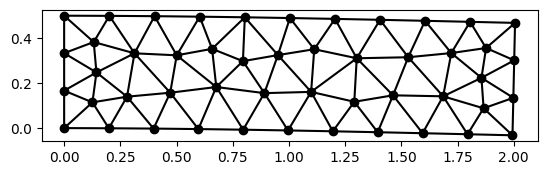

In [12]:
dof_to_coordinate = np.block([range(0, num_global_dofs, 2), range(1, num_global_dofs, 2)])
deformed_geometry = geometry.copy()
deformed_geometry.flat[dof_to_coordinate[free_dofs]] += u_f

plt.gca().set_aspect("equal")
plt.triplot(deformed_geometry[:, 0], deformed_geometry[:, 1], topology, marker="o", color="black")

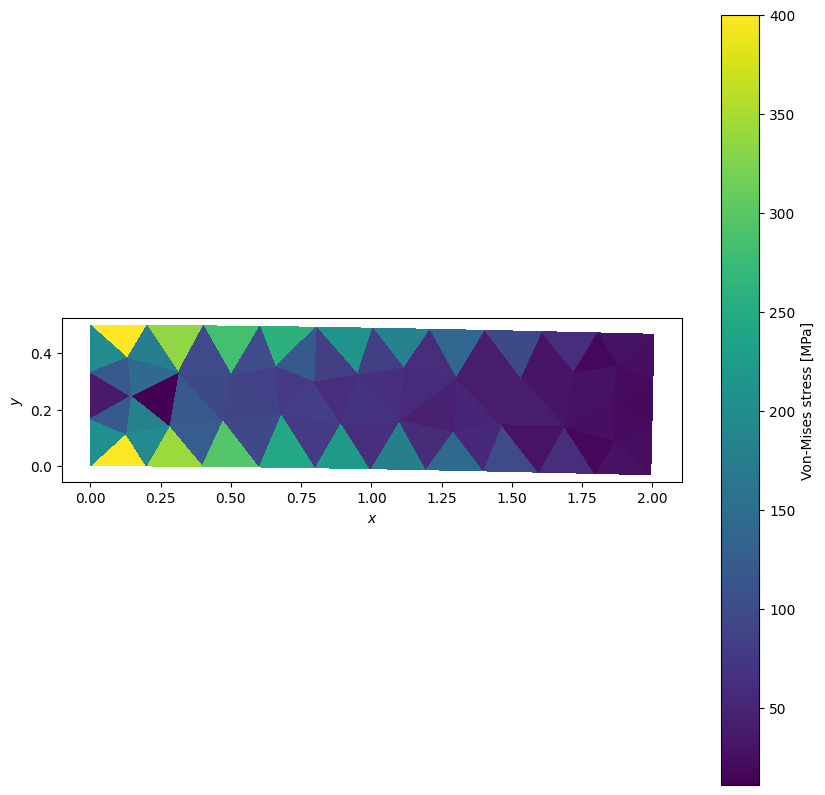

In [13]:
def stress(vertices, u_local):
    J_local = J(vertices)
    detJ = np.linalg.det(J_local)
    basis_deriv_local = basis_deriv(quadrature_point[0], quadrature_point[1])

    basis_deriv_physical = np.linalg.inv(J_local).T @ basis_deriv_local
    B0 = np.array([[basis_deriv_physical[0, 0], 0.0],
                   [0.0, basis_deriv_physical[1, 0]],
                   [basis_deriv_physical[1, 0], basis_deriv_physical[0, 0]]])   
    B1 = np.array([[basis_deriv_physical[0, 1], 0.0],
                   [0.0, basis_deriv_physical[1, 1]],
                   [basis_deriv_physical[1, 1], basis_deriv_physical[0, 1]]]) 
    B2 = np.array([[basis_deriv_physical[0, 2], 0.0],
                   [0.0, basis_deriv_physical[1, 2]],
                   [basis_deriv_physical[1, 2], basis_deriv_physical[0, 2]]]) 

    B = np.block([B0, B1, B2])
    perm = np.array([0, 3, 1, 4, 2, 5])
    u_local = u_local[perm]
    
    S = C@B@u_local
    return von_mises(S[0], S[1], S[2] / 2)


u = np.zeros(num_global_dofs)
u[free_dofs] = u_f

def von_mises(S_xx, S_yy, S_xy):
    return np.sqrt(S_xx**2 - S_xx*S_yy + S_yy**2 + 3*S_xy**2)


vm = np.zeros(num_triangles)
for i in range(num_triangles):
    vertices = geometry[topology[i]]
    u_local = u[dofmap[i]]  
    vm[i] = stress(vertices, u_local)

fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.set_aspect('equal')
tpc = ax1.tripcolor(deformed_geometry[:, 0], deformed_geometry[:, 1], vm / 1e+6, triangles=topology, vmax=400)
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y$")
fig1.colorbar(tpc, label="Von-Mises stress [MPa]")
plt.savefig("vm.pdf")
